# 1. Instalacja oraz konfiguracja podstawowych paczek

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.1.0
comm                         0.1.3
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
executing                    1.2.0
flatbuffers                  23.3.3
fonttools                    4.39.3
gast                         0.4.0
google-auth                  2.17.3
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.54.0
h5py                         3.8.0
idna                         3.4
ipykernel                    6.22.0
ipython                      8.12.0
jax                          0.4.8
jedi                         0.18.2
jupy

In [3]:
import tensorflow as tf
import os

2023-05-02 19:03:57.766362: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 19:03:57.767585: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 19:03:57.790173: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 19:03:57.790594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 19:03:58.230109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [4]:
# Poniższy kod zapobiega  przydzielaniu przez tensorflow całości pamięci GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-05-02 19:03:58.647753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-02 19:03:58.647984: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Weryfikacja, kontrola oraz usunięcie z badania uszkodzonych, wadliwych zdjęć

In [6]:
import cv2
import imghdr

/tmp/ipykernel_13916/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'selected_data'

In [8]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #sprawdzam czy mogę załadować zdjęcie do biblioteki opencv
            tip = imghdr.what(image_path) #sprwadzam czy rozsrzeszenie zdjęcia pokrywa się z akceptowalnymi rozszerzeniami
            if tip not in image_exts:
                print('Zdjęcie posiada nieobsługiwane rozszerzenie {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Wystąpił problem ze zdjęciem {}'.format(image_path))

# 3. Ładowanie danych

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('selected_data') #wywołanie zwróci zestaw danych z wskazanego katalogu, ujednolici, zmniejszy zdjęcia

Found 1208 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator() #konwersja elementów zestawów danych na iterator, pozwoli nam uzyskać dostęp do poszczególnych danych

2023-05-02 19:04:05.897298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1208]
	 [[{{node Placeholder/_4}}]]
2023-05-02 19:04:05.897446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1208]
	 [[{{node Placeholder/_4}}]]


In [13]:
batch = data_iterator.next() #dostęp do zestawu danych, pobranie pierwszej iteracji

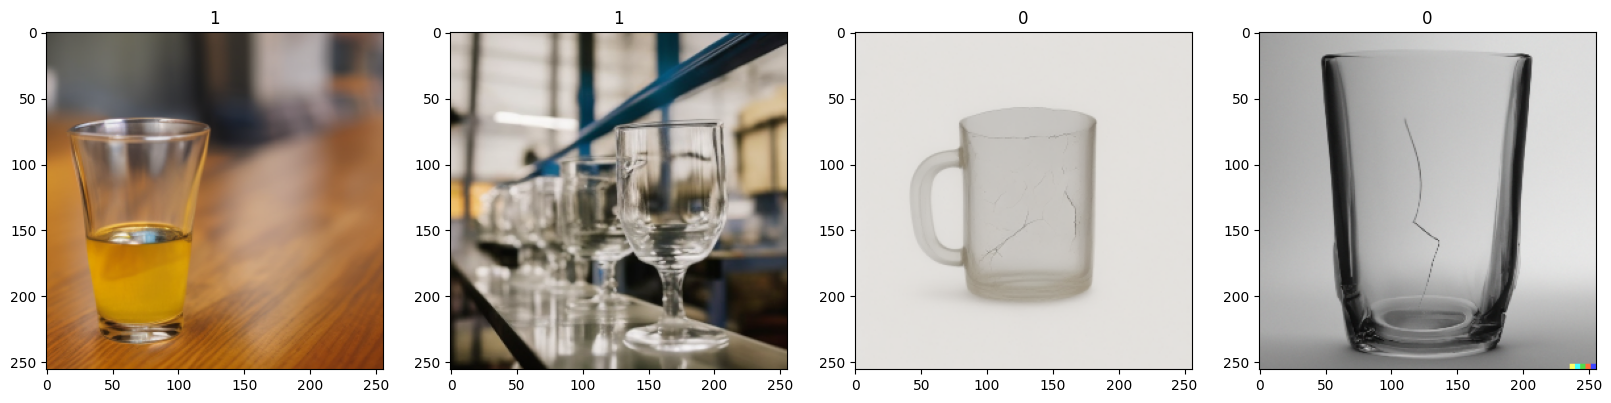

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Wstępne przetwarzanie danych

In [15]:
# przeskalowanie danych, w celu optymalizacji
data = data.map(lambda x,y: (x/255, y)) # funkcja .map umożliwia operacje na całym zestawie danych
data.as_numpy_iterator().next()

2023-05-02 19:04:06.656032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1208]
	 [[{{node Placeholder/_4}}]]
2023-05-02 19:04:06.656175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1208]
	 [[{{node Placeholder/_4}}]]


(array([[[[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],
 
         [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],
 
         [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+

In [16]:
train_size = int(len(data)*.7) # część zestawu danych, która będzie odpowiedzalna za trenowanie modelu
val_size = int(len(data)*.2)+1 # część zestwu danych odpowiedzialna za walidacje
test_size = int(len(data)*.1)+1 # część zestawu danych odpowiedzialna za końcowe testy

In [17]:
train_size

26

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Budowa modelu głębokiego uczenia

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 6. Trenowanie

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15


2023-05-02 19:04:07.220954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1208]
	 [[{{node Placeholder/_4}}]]
2023-05-02 19:04:07.221113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1208]
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.6923

2023-05-02 19:04:10.849607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1208]
	 [[{{node Placeholder/_4}}]]
2023-05-02 19:04:10.849775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1208]
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - 5s 163ms/step - loss: 0.6890 - accuracy: 0.6923 - val_loss: 0.3928 - val_accuracy: 0.8789
Epoch 2/15
26/26 [==============================] - 4s 160ms/step - loss: 0.3547 - accuracy: 0.8498 - val_loss: 0.2707 - val_accuracy: 0.8984
Epoch 3/15
26/26 [==============================] - 4s 161ms/step - loss: 0.2511 - accuracy: 0.9002 - val_loss: 0.2735 - val_accuracy: 0.8945
Epoch 4/15
26/26 [==============================] - 4s 162ms/step - loss: 0.2033 - accuracy: 0.9219 - val_loss: 0.1923 - val_accuracy: 0.9297
Epoch 5/15
26/26 [==============================] - 5s 165ms/step - loss: 0.1269 - accuracy: 0.9591 - val_loss: 0.1778 - val_accuracy: 0.9258
Epoch 6/15
26/26 [==============================] - 4s 163ms/step - loss: 0.1055 - accuracy: 0.9639 - val_loss: 0.1706 - val_accuracy: 0.9453
Epoch 7/15
26/26 [==============================] - 5s 165ms/step - loss: 0.0807 - accuracy: 0.9808 - val_loss: 0.1479 - val_accuracy: 0.9414
Epoch 8/15
26/26 

# 7. Badanie wydajności, wykaz strat

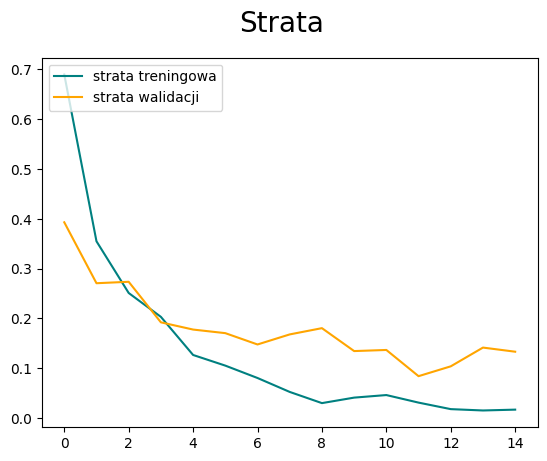

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='strata treningowa')
plt.plot(hist.history['val_loss'], color='orange', label='strata walidacji')
fig.suptitle('Strata', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Badanie wydajności, wykaz dokładności

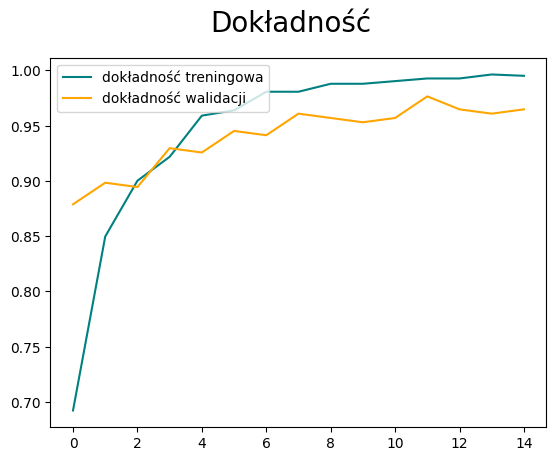

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='dokładność treningowa')
plt.plot(hist.history['val_accuracy'], color='orange', label='dokładność walidacji')
fig.suptitle('Dokładność', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Test

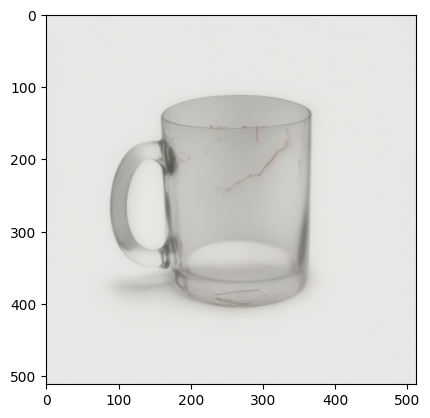

In [107]:
img = cv2.imread('testing/failure_10.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

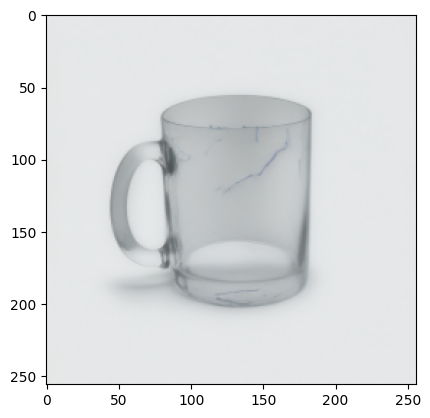

In [108]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [109]:
yhat  = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 10ms/step


In [110]:
yhat

array([[0.00247978]], dtype=float32)

In [38]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część uszkodzona


# 10. Zapis modelu

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models', 'image_classication_25_images.h5'))

In [ ]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.h5'))

img = cv2.imread('testing/failure_4.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

# 11. Ocena modelu

In [ ]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.h5'))
from sklearn.metrics import classification_report

# Ewaluacja modelu na zbiorze testowym
y_test = []
y_pred = []

for images, labels in test:
    predictions = model.predict(images)
    predictions = np.round(predictions).reshape(-1)
    y_test.extend(labels.numpy())
    y_pred.extend(predictions)

# Obliczenie precyzji, czułości (recall) i F1-score
report = classification_report(y_test, y_pred, target_names=['uszkodzony', 'prawidłowy'], output_dict=True)
print(report)

# Wizualizacja raportu klasyfikacji
import seaborn as sns
import pandas as pd

report_df = pd.DataFrame(report).transpose()
report_df = report_df[:-3]  # Usunięcie zbędnych wierszy (accuracy, macro avg, weighted avg)

plt.figure(figsize=(8, 4))
sns.barplot(x=report_df.index, y='f1-score', data=report_df)
plt.ylim(0, 1)
plt.title('F1-score dla poszczególnych klas')
plt.xlabel('Klasy')
plt.ylabel('F1-score')
plt.show()